In [166]:
import pandas as pd
import numpy as np
import math
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
import utils
%matplotlib inline

In [167]:
FIXED_DATA = ['3u_fixed_x_1.txt', '3mf_I=74.9_A=3_f=.5_tot=2.txt']
FLOATING_DATA = ['3ml_I=744.9_r=5000_tot=1.txt', '3ml_I=744.9_r=5000_tot=1 2.txt']

def load_data(file):
    return pd.read_csv(file, delim_whitespace = True, names=['qpdx', 'qpdy', 'sgx', 'sgy'])

In [168]:
def linear(x, a, b):
    return a*x + b

In [215]:
# STRAIN GAUGE CALIBRATION
# Find strain gauge voltage to distance conversion factors kx and ky
# data recorded by hand
vx = [5.058, 5.076, 5.1, 5.122, 5.15, 5.165, 5.187, 5.215]
x = [10.116, 10.152, 10.2, 10.245, 10.299, 10.331, 10.375, 10.431]
popt, perr, redchisq = utils.fit_model(vx, x, [5e-4]*len(vx), (2, 0), linear)
#print(redchisq)
kx = popt[0]
ekx = perr[0]

vy = [4.992, 5.012, 5.029, 5.055, 5.084, 5.109, 5.123, 5.139]
y = [9.985, 10.024, 10.059, 10.111, 10.168, 10.219, 10.247, 10.278]
popt, perr, redchisq = utils.fit_model(vy, y, [5e-4]*len(vx), (2, 0), linear)
#print(redchisq)
ky = popt[0]
eky = perr[0]

print('kx = ', kx, '+/-', ekx, 'micron?/V')
print('ky = ', ky, '+/-', eky, 'micron?/V')

kx =  2.00649763858 +/- 0.00344812153631 lengths/V
ky =  1.99847730238 +/- 0.0034832531991 lengths/V


236.319486099
qx =  35.8173775897 +/- 0.00219381414467  lengths/mV
qy =  35.8173775897 +/- 0.00219381414467  lengths/mV


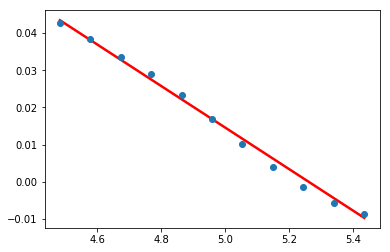

In [216]:
# QPD CALIBRATION
# Find qpd voltage to distance conversion factors qx and qy as functions of laser power

fixed_data = load_data('opttrap/' + FIXED_DATA[0])

# rebin data
BINS = 100
fixed_data['bin'] = pd.cut(fixed_data['sgx'], bins=BINS)
meanbin = fixed_data.groupby('bin').mean()
# TODO: discuss std err on the mean is a good measure of error
stdbin = fixed_data.groupby('bin').std()/(len(fixed_data)/BINS)**.5 

# plot data
#plt.plot(meanbin['sgx'], meanbin['qpdx'])
#plt.show()

# select linear range
SG1 = 42
SG2 = 53

popt, perr, redchisq = utils.fit_model(meanbin['sgx'][SG1:SG2], meanbin['qpdx'][SG1:SG2], stdbin['qpdx'][SG1:SG2], (-1, 10), linear)
print(redchisq)
qx = kx / abs(popt[0]) # [lengths / sg volts] * [sg volts / qpd volts]
eqx = ((ekx/kx)**2 + (perr[0]/popt[0])**2)**.5
print('qx = ', qx, '+/-', eqx, ' micron?/mV')

# assume symmetry until we have more data
qy = qx
eqy = eqx
print('qy = ', qy, '+/-', eqy, ' micron?/mV')

utils.plot_data(meanbin['sgx'][SG1:SG2], meanbin['qpdx'][SG1:SG2], stdbin['qpdx'][SG1:SG2])
utils.plot_model(meanbin['sgx'][SG1:SG2], linear, popt, 'r', '')
plt.show()

In [219]:
# EQUIPARTITION THEOREM ANALYSIS
# \alpha <r^2> = k_B T

# TODO: adjust for stage movement???

floating_data = load_data('opttrap/' + FLOATING_DATA[0])

# calculate <r^2> with correction for <r>
# this is the same as the variance
var = floating_data.var()
varx = var['qpdx']
vary = var['qpdy']

# calculate the error on the variance
# by averaging the errors on the squared x and y redsiduals
floating_data['erxsq'] = (2 * (floating_data['qpdx'] - floating_data['qpdx'].mean()) * 2*5e-8)**2
floating_data['erysq'] = (2 * (floating_data['qpdy'] - floating_data['qpdy'].mean()) * 2*5e-8)**2 
evarx = floating_data['erxsq'].mean()**.5
evary = floating_data['erysq'].mean()**.5

r2 = ( qx**2 * varx + qy**2 * vary ) / 10e6**2
er2 = (qx**2 * varx) * ((2*qx*eqx / qx)**2 + (evarx / varx)**2)**.5 / 10e6**2
+ (qy**2 * vary) * ((2*qy*eqy / qy)**2 + (evary / vary)**2)**.5

print('<r^2> = ',  r2, '+/-', er2, 'm')

<r^2> =  5.6785874271e-16 +/- 1.50526918418e-18 m


In [221]:
# Assuming we're looking for k_B
# \alpha <r^2> = k_B T

# Temperature based on my memory (fix with actual)
t = 22.4 + 273
et = 1

# Need to get alpha from a different calculation
a = 1 # dummy
ea = 0 # dummy

kB = a * r2 / t
ekB = kB * ((ea / a)**2 + (er2 / r2)**2 + (et / t)**2)**.5
print('kB/a = ', kB, '+/-', ekB)
print(1/kB * 1.38e-23)

kB/a =  1.92233833009e-18 +/- 8.26527071903e-21
7.17875713342e-06


0.659416882255
[  6.37941234e-06   1.23639280e-07]
[  2.11526336e-06   6.25189761e-08]


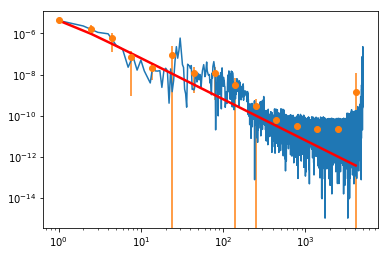

In [310]:
# PSD Analysis
floating_data = load_data('opttrap/' + FLOATING_DATA[0])

fft = np.fft.fft(floating_data['qpdx'])

r = 5000 # samples / s
psd = pd.DataFrame()
psd['f'] = pd.Series(np.arange(0, len(fft) / (len(fft) - 1) * r, r / (len(fft) - 1)))
psd['xf'] = pd.Series(np.real(fft*np.conjugate(fft)) / r**2)

# bin data
nbins = 16
BINS = np.array([10**i for i in np.arange(0, 4, 4/nbins)])
psd['bin'] = pd.cut(psd['f'], bins=BINS)
psd = psd.drop(0) # drop 0 frequency

groupedpsd = psd.groupby('bin') # gropu data by bin

# drop outliers (over 2 sigma away from bin's mean)
psd['outlier'] = groupedpsd['xf'].apply(lambda group: np.abs(group - group.mean()) > 2*group.std())
psd = psd[psd['outlier'] == False]

groupedpsd = psd.groupby('bin') # regroup after throwing out outliers

# bin data to find means and error
meanbin = groupedpsd.mean()
meanbin = meanbin[pd.notnull(meanbin['f'])] # remove bins that don't have values?
meanbin['exf'] = psd.groupby('bin').std()['xf']
meanbin = meanbin.fillna(1e-8) # TODO: figure out how to bin so that there isn't just 1 value in some bins
#print(meanbin)

# fit to psd model
def psdmodel(f, A, a):
    b = 3 * 3.14159 * 9.34e-4 * 3.2e-6 # 3 pi nu [Pa*s] d [m]
    return A / (f**2 + (a/2/3.14159/b)**2)

popt, perr, redchisq = utils.fit_model(meanbin['f'], meanbin['xf'], meanbin['exf'], (1, 1e-6), psdmodel)
print(redchisq)
print(popt)
print(perr)

plt.plot(psd['f'], psd['xf'])
utils.plot_data(meanbin['f'], meanbin['xf'], meanbin['exf'])
#utils.plot_model(meanbin['f'], psdmodel, (1e-5, 1e-7), 'k', '')
utils.plot_model(meanbin['f'], psdmodel, popt, 'r', '')
plt.yscale('log')
plt.xscale('log')
plt.show()